In [ ]:
pip install numpy

In [2]:

pip install scikit-surprise

In [3]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
%matplotlib inline



from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time


import warnings
warnings.filterwarnings("ignore")

import pickle

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd

In [7]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
df_movies = pd.read_csv('/content/drive/MyDrive/movies.csv')
df_imdb = pd.read_csv('/content/drive/MyDrive/imdb_data.csv')
df_gtags = pd.read_csv('/content/drive/MyDrive/genome_tags.csv')
df_scores = pd.read_csv('/content/drive/MyDrive/genome_scores.csv')
df_tags = pd.read_csv('/content/drive/MyDrive/tags.csv')
df_links = pd.read_csv('/content/drive/MyDrive/links.csv')

In [8]:
df_imdb.info()
df_imdb.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


In [7]:
# viewing movie data
df_movies.info()
df_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
#viewing
df_gtags.info()
df_gtags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [9]:
df_scores.info()
df_scores.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375


In [10]:
df_tags.info()
df_tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [11]:
df_links.info()
df_links.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [12]:
#viewing training data (splitted from tags_df)
train.head()


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [13]:
#check for missing values
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [14]:
# check duplicates in train dataframe
duplicate_bool = train.duplicated(['userId', 'movieId', 'rating'])

# display duplicates
print("Number of duplicate records:", sum(duplicate_bool))

Number of duplicate records: 0


In [15]:
# Create a copy of the train data
df_train = train
df_train.head(2)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739


In [16]:
# Merge train and movies

combined_df = df_train.merge(df_movies, on='movieId')

combined_df.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [17]:
#merged train and imdb dataset
combined_df2 = df_train.merge(df_imdb, on="movieId")
combined_df2.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [18]:
# Merging the merge combined_df on with the df_imbd
combined_df3 = combined_df.merge(df_imdb, on="movieId" )
combined_df3.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [19]:
# Check the null values of the data that has just been merged.
combined_df3.isnull().sum()

userId                 0
movieId                0
rating                 0
timestamp              0
title                  0
genres                 0
title_cast       2604407
director         2602688
runtime          2653058
budget           3152276
plot_keywords    2610043
dtype: int64

In [20]:
# View keywords
combined_df3['plot_keywords'].tail(100)

9632931                                                NaN
9632932    sex|male frontal nudity|prostitution|perversity
9632933                                     color in title
9632934                                                NaN
9632935         murder|serial killer|peeping|female nudity
                                ...                       
9633026                                                NaN
9633027      janitor|income|housing problem|social problem
9633028                                                NaN
9633029                     soldier|italy|partisan|fascist
9633030             genius|artist|greek american|direction
Name: plot_keywords, Length: 100, dtype: object

In [21]:
# Extract unique values from rating column
train['rating'].unique()

array([4. , 4.5, 5. , 2. , 3. , 1. , 3.5, 2.5, 0.5, 1.5])

In [22]:
# Get summary statistics for column rating
train['rating'].describe()

count    1.000004e+07
mean     3.533395e+00
std      1.061124e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [23]:
rating_per_user = df_train.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending = False)
rating_per_user.head()

,userId,rating
72314,72315,12952
80973,80974,3680
137292,137293,3588
33843,33844,3208
20054,20055,3050


In [30]:
import plotly.graph_objects as go

In [35]:
data = combined_df['rating'].value_counts().sort_index(ascending=False)

# Create trace
trace = go.Bar(x=data.index,
               text=['{:.1f} %'.format(val) for val in (data.values / combined_df.shape[0] * 100)],
               textposition='auto',
               textfont=dict(color='#000000'),
               y=data.values,
               marker=dict(color='#db0000'))
# Create layout
layout = dict(title='Distribution Of {} movie-ratings'.format(combined_df.shape[0]),
              xaxis=dict(title='rating'),
              yaxis=dict(title='Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [36]:
ranked_movies = combined_df3.groupby('title')['rating'].mean().sort_values(ascending = False)
ranked_movies.head()

title
Wrestling for Jesus: The Tale of T-Money (2011)    5.0
The... Beautiful Country (1977)                    5.0
Only Daughter (2013)                               5.0
Vasermil (2007)                                    5.0
Day the Universe Changed, The (1985)               5.0
Name: rating, dtype: float64

In [60]:
combined_df3.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)
#Create dataframe
num_ratings = pd.DataFrame(combined_df3.groupby('movieId').count()['rating']).reset_index()
#merge num ratings with combined_df3
combined_df3 = pd.merge(left=combined_df3, right=num_ratings, on='movieId')
# rename columns
combined_df3.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)

In [62]:
# Convert 'budget' to string
combined_df3['budget'] = combined_df3['budget'].astype(str)

# Remove commas
combined_df3['budget'] = combined_df3['budget'].str.replace(',', '')

# Remove currency signs like "$" and "GBP"
combined_df3['budget'] = combined_df3['budget'].str.replace('[$£]', '', regex=True)

# Convert the 'budget' column to numeric (float)
combined_df3['budget'] = pd.to_numeric(combined_df3['budget'], errors='coerce')

# Now you can proceed with your further processing

# For example, if you want to replace NaN values with 0:
combined_df3['budget'] = combined_df3['budget'].fillna(0)


In [63]:
#extracting date from title column
combined_df3['release_year'] = combined_df3.title.str.extract('(\(\d\d\d\d\))', expand=False)

#adding date to realse year column
combined_df3['release_year'] = combined_df3.release_year.str.extract('(\d\d\d\d)', expand=False)

#view top 2 rows of the dataframe
combined_df3.head(2)

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords,numRatings,numRatings,numRatings,release_year
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,15000000.0,dwarf|bruges|irish|hitman,4253,4253,4253,2008
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,15000000.0,dwarf|bruges|irish|hitman,4253,4253,4253,2008


In [64]:
#drop duplicates on dataframe
data_1= combined_df3.drop_duplicates('movieId')

#view top 2 rows of the dataframe
data_1.head(2)

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords,numRatings,numRatings,numRatings,release_year
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,15000000.0,dwarf|bruges|irish|hitman,4253,4253,4253,2008
4253,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,30000000.0,fatherhood|doberman|dog|mansion,4648,4648,4648,1995


In [66]:
import matplotlib.pyplot as plt

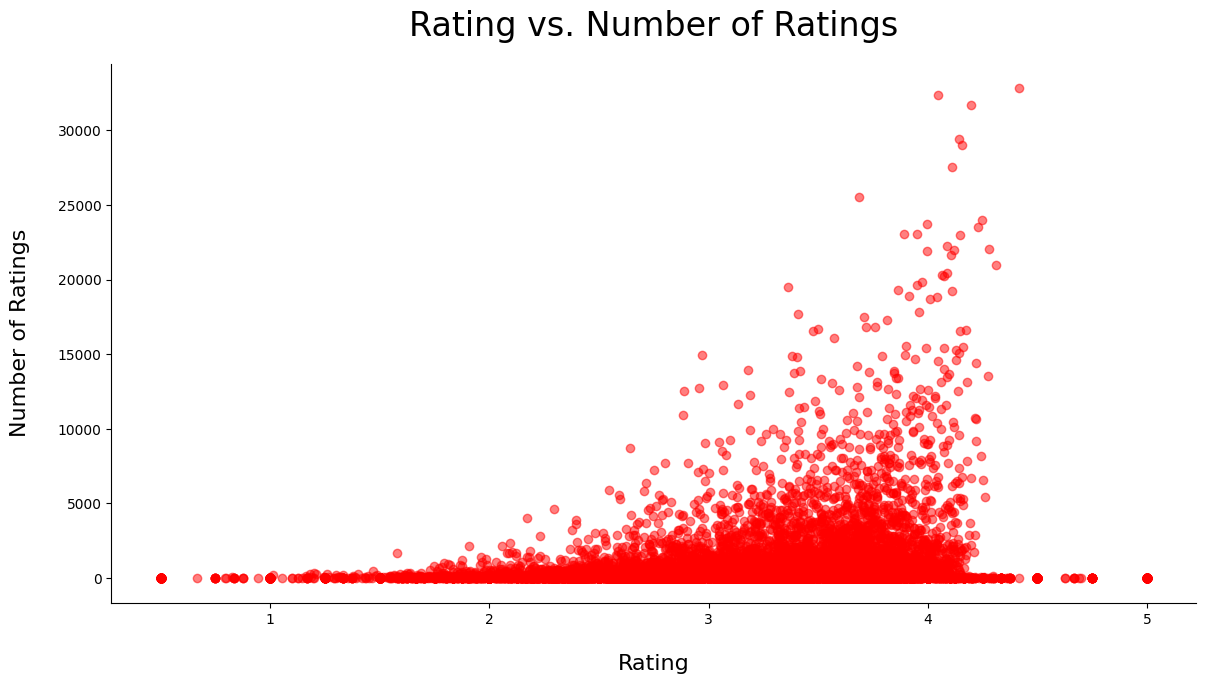

In [67]:
#create ratings dataframe
ratings_df = pd.DataFrame()

#extract average ratings
ratings_df['Mean_Rating'] = combined_df3.groupby('title')['rating'].mean().values

#extract average number of ratings
ratings_df['Num_Ratings'] = combined_df3.groupby('title')['rating'].count().values

#make a plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Rating vs. Number of Ratings', fontsize=24, pad=20)
ax.set_xlabel('Rating', fontsize=16, labelpad=20)
ax.set_ylabel('Number of Ratings', fontsize=16, labelpad=20)

plt.scatter(ratings_df['Mean_Rating'], ratings_df['Num_Ratings'], alpha=0.5, color='red')

In [68]:
#make census of the genre keywords
list_list =list(df_movies['genres'].str.split('|'))
genres_list = []
for i in list_list:
    for j in i:
        genres_list.append(j)
print(genres_list[0:11])
print(len(genres_list))

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Adventure', 'Children', 'Fantasy', 'Comedy', 'Romance', 'Comedy']
112307


In [69]:
genres_list = pd.DataFrame(genres_list)
genres_list.rename(columns ={0:'genres'},inplace = True)
genres_list.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112307 entries, 0 to 112306
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   genres  112307 non-null  object
dtypes: object(1)
memory usage: 877.5+ KB


In [70]:
genres_counted = pd.DataFrame(genres_list['genres'].value_counts())

In [71]:
#count the number of times each genre keywords appears
genres_counted.reset_index(inplace = True)
genres_counted.rename(columns = {'index':'genres','genres': 'count'}, inplace = True)
genres_counted.head()
#genres_counted.info()

,genres,count
0,Drama,25606
1,Comedy,16870
2,Thriller,8654
3,Romance,7719
4,Action,7348


In [72]:
genome_df = pd.merge(df_scores, df_gtags, how = 'left', on = 'tagId')
genome_df.head()

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,1,2,0.02375,007 (series)
2,1,3,0.06250,18th century
3,1,4,0.07575,1920s
4,1,5,0.14075,1930s


In [73]:
df_genre_tag = genome_df.merge(df_movies, on = 'movieId', how = 'outer')
df_genre_tag.head(2)

,movieId,tagId,relevance,tag,title,genres
0,1,1.0,0.02875,007,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2.0,0.02375,007 (series),Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

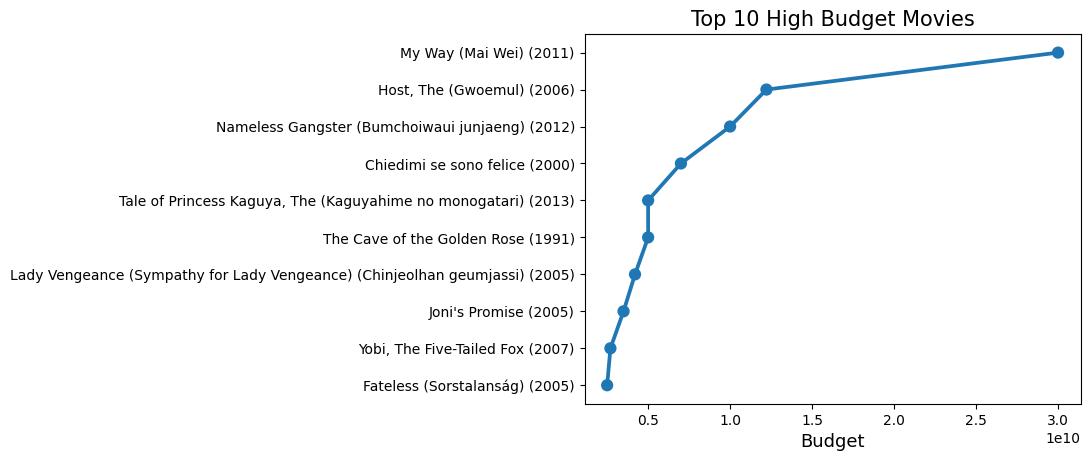

In [78]:
#make a plot which contain top 10 highest budget movies.
#sort the 'budget' column in decending order and store it in the new dataframe.
info = pd.DataFrame(data_1['budget'].sort_values(ascending = False))
info['title'] = data_1['title']
data = list(map(str,(info['title'])))

#extract the top 10 budget movies data from the list and dataframe.
x = list(data[:10])
y = list(info['budget'][:10])

#plot the figure and setup the title and labels.
ax = sns.pointplot(x=y,y=x)
sns.set(rc={'figure.figsize':(10,5)})
ax.set_title("Top 10 High Budget Movies",fontsize = 15)
ax.set_xlabel("Budget",fontsize = 13)
sns.set_style("darkgrid")

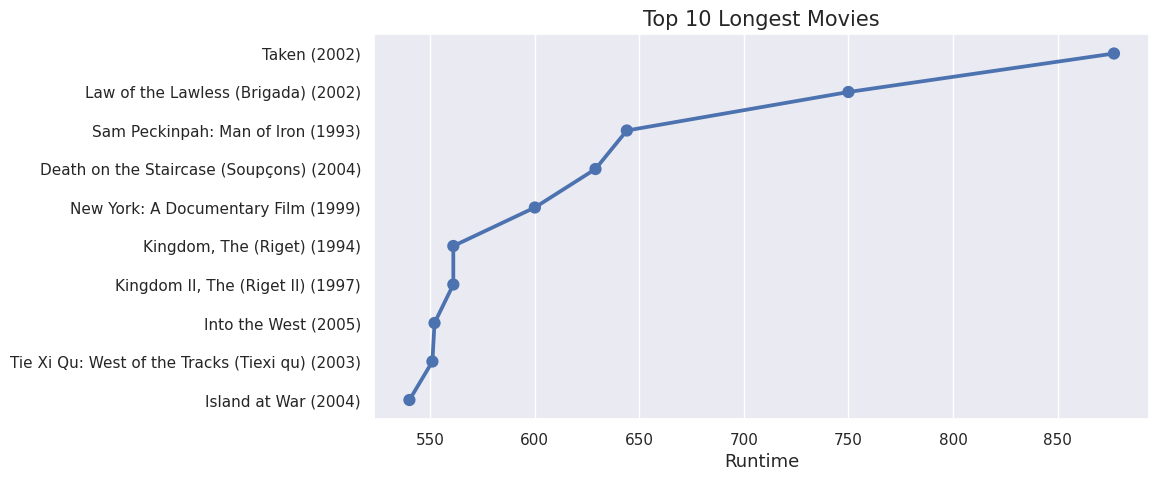

In [79]:
#top 10 Movies With Longest runtime
#sort the 'runtime' column in decending order and store it in the new dataframe.
info = pd.DataFrame(data_1['runtime'].sort_values(ascending = False))
info['title'] = data_1['title']
data = list(map(str,(info['title'])))

#extract the top 10 longest duraton movies data from the list and dataframe.
x = list(data[:10])
y = list(info['runtime'][:10])

#make the point plot and setup the title and labels.
ax = sns.pointplot(x=y,y=x)
sns.set(rc={'figure.figsize':(10,5)})
ax.set_title("Top 10 Longest Movies",fontsize = 15)
ax.set_xlabel("Runtime",fontsize = 13)
sns.set_style("darkgrid")

<ipython-input-80-4b3a05888206>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



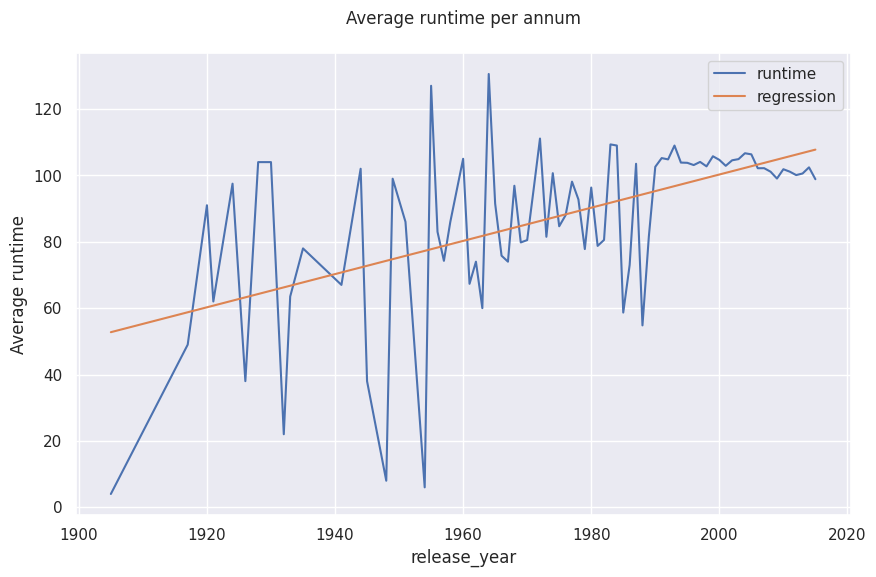

In [80]:
from sklearn.linear_model import LinearRegression

# create a dataframe with runtime data
runtime_data = pd.DataFrame(data_1.dropna().groupby('release_year').mean()['runtime']).dropna()
runtime_data.index = runtime_data.index.astype('int')
runtime_data = runtime_data[runtime_data['runtime']>1].copy()

# train a linear regression model for the trend
lrm = LinearRegression()
runtime_data = runtime_data.reset_index()
lrm.fit(runtime_data.release_year.values.reshape(-1,1),runtime_data.runtime.values.reshape(-1,1))

# make predictions
runtime_data['regression'] = lrm.predict(runtime_data.release_year.values.reshape(-1,1))

# visualize the runtime per annum
runtime_data = runtime_data.set_index('release_year')
runtime_data.plot(figsize=(10,6))
plt.title("Average runtime per annum\n")
plt.ylabel("Average runtime")
plt.show()

<ipython-input-81-d5a97f4cd5e6>:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-81-d5a97f4cd5e6>:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



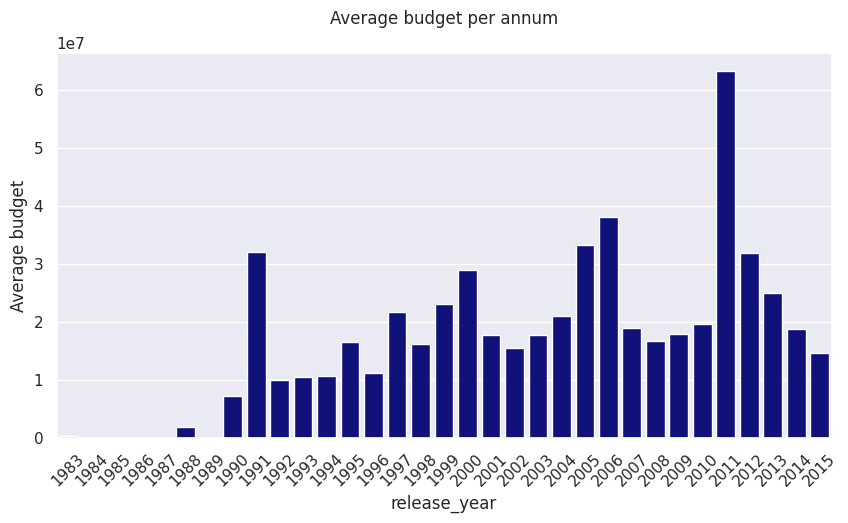

In [81]:
# create a dataframe with budget data
budget_data = pd.DataFrame(data_1.dropna().groupby('release_year').mean()['budget']).dropna()
budget_data.index = budget_data.index.astype('int')
runtime_data = budget_data[budget_data['budget']>1].copy()

# # make predictions
budget_data = budget_data.reset_index()
budget_data = budget_data.drop('budget',1).merge(pd.DataFrame(budget_data[budget_data['release_year']>1982]), on ='release_year')

# # visualize the budget per annum
plt.figure(figsize=(10,5))
sns.barplot(x='release_year',y='budget',data=budget_data, color='darkblue')
plt.title("Average budget per annum\n")
plt.ylabel("Average budget")
plt.xticks(rotation=45)
plt.show()

In [19]:
def plot_correlation_map( df ):

    """"
    This function gives a correlation map
    using all the features from merged data.

    Input : dataframe column
    datatype : dataframe (integer)

    output : Figure (bar plot)

    """
    # Plotting using the features

    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

In [9]:
movies = df_movies

In [10]:
df_1 = df_imdb[['movieId','title_cast','director', 'plot_keywords']]
df_1 = df_1.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df_1.head(2)

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)


In [12]:
# Convert data types to strings for string handling
df_1['title_cast'] = df_1.title_cast.astype(str)
df_1['plot_keywords'] = df_1.plot_keywords.astype(str)
df_1['genres'] = df_1.genres.astype(str)
df_1['director'] = df_1.director.astype(str)

# Removing spaces between names
df_1['director'] = df_1['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df_1['title_cast'] = df_1['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df_1['title_cast'] = df_1['title_cast'].map(lambda x: x.split('|'))

# Discarding the pipes between the plot keywords' and getting only the first five words
df_1['plot_keywords'] = df_1['plot_keywords'].map(lambda x: x.split('|'))
df_1['plot_keywords'] = df_1['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres
df_1['genres'] = df_1['genres'].map(lambda x: x.lower().split('|'))
df_1['genres'] = df_1['genres'].apply(lambda x: " ".join(x))

df_1.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles, jimvarney, wa...",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst, br...",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren, ann-m...",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine,...",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort, kimber...",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ML Pre processing
from surprise.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
from surprise.model_selection import GridSearchCV

In [14]:
#we convert the tille_cast column from list to string
df_1['liststring'] = df_1['title_cast'].apply(lambda x: ','.join(map(str, x)))

#we remove the commas between the string in each row
df_1['liststring'] = df_1['liststring'].replace(',',' ', regex=True)

#we choose keywords, cast(liststring), diector and genres column to use as our features
df_features = df_1[['liststring','director','plot_keywords','genres']]

#we combine the features columns into  single string
df_1['combined_features'] = df_features['liststring'] +' '+ df_features['director'] +' '+ df_features['plot_keywords'] +' '+ df_features['genres']

#we now feed the combined features to a CountVectorizer() object for getting the cv matrix.
cv =CountVectorizer()
cv_matrix = cv.fit_transform(df_1['combined_features'])

#now we obtain the cosine similarity matrix from the cv matrix
sim_score = cosine_similarity(cv_matrix,cv_matrix)

df_1.set_index('title', inplace = True)
indices = pd.Series(df_1.index)

In [19]:
print(sim_score)

[[1.         0.10910895 0.07715167 ... 0.03026138 0.         0.07881104]
 [0.10910895 1.         0.         ... 0.06163336 0.         0.08025724]
 [0.07715167 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.03026138 0.06163336 0.         ... 1.         0.         0.03338903]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.07881104 0.08025724 0.         ... 0.03338903 0.         1.        ]]


In [20]:
#Method to get recommenations
def recommendations(title,n,sim_score = sim_score):
    '''
    This method returns movies which are similar.

    Input:
        title: name of the movie to be compared
        n: number(quantity) of movies to be returned
        sim_core: similarity score
    Output:
        recommend movies
    '''

    recommended_movies = []

    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(sim_score[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_n_indexes = list(score_series.iloc[1:n+1].index)

    # populating the list with the titles of the best n matching movies
    for i in top_n_indexes:
        recommended_movies.append(list(df_1.index)[i])

    return recommended_movies

In [21]:
recommendations('Innocence (2014)',10)

['King Kong (1933)',
 'Zu: Warriors from the Magic Mountain (Xin shu shan jian ke) (1983)',
 'Island of Dr. Moreau, The (1977)',
 'The Man in the Orange Jacket (2014)',
 'She (1965)',
 'Printed Rainbow (2006)',
 'MirrorMask (2005)',
 'Seventh Son (2014)',
 'The Prophecy: Forsaken (2005)',
 'The Damned (2014)']

In [15]:
# Load reader and data in Surprise dataframe
df_train = train.copy()
reader = Reader(rating_scale = (0.5, 5))
# Data selected for model training
data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], reader)

In [11]:
# Split data train/test= 99/0.1
trainset, testset = train_test_split(data, test_size=0.1)

NameError: ignored

In [14]:
# Base algorithm
algo = SVD()
algo.fit(trainset)

NameError: ignored

In [25]:
# Using the 10% testset to make predictions
predictions = algo.test(testset)
predictions

test = pd.DataFrame(predictions)

In [26]:
# View the test data
test.head()

,uid,iid,r_ui,est,details
0,72077,2076,3.5,3.658323,{'was_impossible': False}
1,154947,1089,4.5,4.241748,{'was_impossible': False}
2,129695,42004,2.0,2.568818,{'was_impossible': False}
3,75457,468,4.0,3.306905,{'was_impossible': False}
4,15496,2985,2.0,2.701693,{'was_impossible': False}


In [13]:
# We are trying to predict ratings for every userId / movieId pair, we implement the below list comprehension to achieve this.
ratings_predictions=[algo.predict(row.userId, row.movieId) for _,row in test_df.iterrows()]
ratings_predictions

NameError: ignored

In [12]:
# Converting our prediction into a familiar format-Dataframe
df_pred=pd.DataFrame(ratings_predictions)
df_pred

NameError: ignored

In [ ]:
# Renaming our predictions to original names
df_pred=df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
df_pred.drop(['r_ui','details'],axis=1,inplace=True)

In [ ]:
# Snippet of our ratings
df_pred.head()

In [ ]:
# Concatenating userId/movieId into a single Id column.(code has to be run twice to get desired outcome)
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [ ]:
# View the first five rows of the dataframe
df_pred.head()

In [ ]:
# Drop the columns: 'userId' and 'movieId'
df_pred.drop(['userId', 'movieId'], inplace=True, axis= 1)

In [ ]:
# View the predicted dataset
df_pred = df_pred[['Id', 'rating']]

In [ ]:
# View the first 5 rows
df_pred.head()

In [ ]:
# View the shape of the dataset to be submitted
df_pred.shape

In [ ]:
# The submitted base model
df_pred.to_csv("Busisiwe_Dlala.csv", index=False)